In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import timeit
import mlrose_hiive as mlrose

%run utility_functions.py # functions reused throughout

-1    4849
 1    1001
Name: cleave, dtype: int64

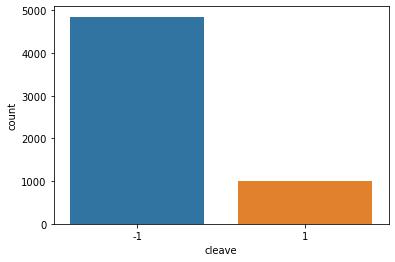

In [2]:
# Dataset source:
#http://archive.ics.uci.edu/ml/datasets/HIV-1+protease+cleavage#
# combined all datasets, removing duplicates
# Read in data
data = pd.read_csv('../data/HIV_DataSet.csv', sep=',')


sns.countplot(data['cleave']) # plot number of things with each value
# number of negative cleave values versus positive.
data['cleave'].value_counts(sort=True)

In [4]:
# Create training, testing, and validation sets

X = data.drop('cleave', axis=1) # last value is the cleavage

y = data['cleave']
y = y.replace(-1, 0)

from imblearn.under_sampling import RandomUnderSampler
#https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
# add undersampling of majority class to improve performance.
undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale so it converges
scaling = MinMaxScaler(feature_range=(0,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)

In [5]:
# HILLCLIMB HPARAM
# frozen parameters from optimized backprop scikit neural network (not all available in mlrose):
'''
{'activation': 'relu','alpha': 0.001,'batch_size': 'auto','beta_1': 0.9,'beta_2': 0.999,'early_stopping': True,'epsilon': 1e-08,
 'hidden_layer_sizes': (5, 5, 5, 5),'learning_rate': 'constant', 'learning_rate_init': 0.001,'max_fun': 15000,'max_iter': 200,
 'momentum': 0.9,'n_iter_no_change': 40,'nesterovs_momentum': True,'power_t': 0.5,'random_state': 0,'shuffle': True,'solver': 'adam',
 'tol': 0.0001,'validation_fraction': 0.1,'verbose': False,'warm_start': False}
'''
    
clf_rhc = mlrose.NeuralNetwork(algorithm='random_hill_climb',
    hidden_nodes = [5, 5, 5, 5], activation = 'relu', early_stopping=True, 
    random_state=0, is_classifier=True, bias=True)

parameters = {'max_iters': [100, 200, 300],
              'restarts': [1, 2, 3, 4, 5],
              'max_attempts': [10, 20, 30, 40],
              'learning_rate': [.001, .01, .1]}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf_rhc, parameters, scoring=acc_scorer, cv=5, n_jobs=8)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
clf_rhc = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf_rhc.fit(x_train, y_train)


NeuralNetwork(early_stopping=True, hidden_nodes=[5, 5, 5, 5], max_iters=300,
              random_state=0, restarts=2)

In [7]:
clf_rhc.get_params()

{'activation': 'relu',
 'algorithm': 'random_hill_climb',
 'bias': True,
 'clip_max': 10000000000.0,
 'curve': False,
 'early_stopping': True,
 'hidden_nodes': [5, 5, 5, 5],
 'is_classifier': True,
 'learning_rate': 0.1,
 'max_attempts': 10,
 'max_iters': 300,
 'mutation_prob': 0.1,
 'pop_size': 200,
 'random_state': 0,
 'restarts': 2,
 'schedule': GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)}

In [8]:
# SIMANNEAL HPARAM
# frozen parameters from optimized backprop scikit neural network (not all available in mlrose):
'''
{'activation': 'relu','alpha': 0.001,'batch_size': 'auto','beta_1': 0.9,'beta_2': 0.999,'early_stopping': True,'epsilon': 1e-08,
 'hidden_layer_sizes': (5, 5, 5, 5),'learning_rate': 'constant', 'learning_rate_init': 0.001,'max_fun': 15000,'max_iter': 200,
 'momentum': 0.9,'n_iter_no_change': 40,'nesterovs_momentum': True,'power_t': 0.5,'random_state': 0,'shuffle': True,'solver': 'adam',
 'tol': 0.0001,'validation_fraction': 0.1,'verbose': False,'warm_start': False}
'''

clf_sa = mlrose.NeuralNetwork(algorithm='simulated_annealing',
    hidden_nodes = [5, 5, 5, 5], activation = 'relu', early_stopping=True, 
    random_state=0, is_classifier=True, bias=True)

parameters = {'max_iters': [100, 200, 300],
              'schedule': [mlrose.GeomDecay(), mlrose.ExpDecay()],
              'max_attempts': [10, 20, 30, 40],
              'learning_rate': [.001, .01, .1]}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf_sa, parameters, scoring=acc_scorer, cv=5, n_jobs=8)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
clf_sa = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf_sa.fit(x_train, y_train)

NeuralNetwork(algorithm='simulated_annealing', early_stopping=True,
              hidden_nodes=[5, 5, 5, 5], learning_rate=0.001, max_attempts=20,
              max_iters=200, random_state=0)

In [9]:
clf_sa.get_params()

{'activation': 'relu',
 'algorithm': 'simulated_annealing',
 'bias': True,
 'clip_max': 10000000000.0,
 'curve': False,
 'early_stopping': True,
 'hidden_nodes': [5, 5, 5, 5],
 'is_classifier': True,
 'learning_rate': 0.001,
 'max_attempts': 20,
 'max_iters': 200,
 'mutation_prob': 0.1,
 'pop_size': 200,
 'random_state': 0,
 'restarts': 0,
 'schedule': GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)}

In [10]:
# GENETIC ALGO HPARAM
# frozen parameters from optimized backprop scikit neural network (not all available in mlrose):
'''
{'activation': 'relu','alpha': 0.001,'batch_size': 'auto','beta_1': 0.9,'beta_2': 0.999,'early_stopping': True,'epsilon': 1e-08,
 'hidden_layer_sizes': (5, 5, 5, 5),'learning_rate': 'constant', 'learning_rate_init': 0.001,'max_fun': 15000,'max_iter': 200,
 'momentum': 0.9,'n_iter_no_change': 40,'nesterovs_momentum': True,'power_t': 0.5,'random_state': 0,'shuffle': True,'solver': 'adam',
 'tol': 0.0001,'validation_fraction': 0.1,'verbose': False,'warm_start': False}
'''

clf_ga = mlrose.NeuralNetwork(algorithm='genetic_alg',
    hidden_nodes = [5, 5, 5, 5], activation = 'relu', early_stopping=True, 
    random_state=0, is_classifier=True, bias=True)

parameters = {'max_iters': [100, 200, 300],
              'pop_size': [50, 100, 200],
              'mutation_prob': [.1, .2, .3],
              'max_attempts': [10, 20, 30, 40],
              'learning_rate': [.001, .01, .1]}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf_ga, parameters, scoring=acc_scorer, cv=5, n_jobs=8)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
clf_ga = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf_ga.fit(x_train, y_train)

NeuralNetwork(algorithm='genetic_alg', early_stopping=True,
              hidden_nodes=[5, 5, 5, 5], max_attempts=40, max_iters=300,
              random_state=0)

In [12]:
clf_ga.get_params()

{'activation': 'relu',
 'algorithm': 'genetic_alg',
 'bias': True,
 'clip_max': 10000000000.0,
 'curve': False,
 'early_stopping': True,
 'hidden_nodes': [5, 5, 5, 5],
 'is_classifier': True,
 'learning_rate': 0.1,
 'max_attempts': 40,
 'max_iters': 300,
 'mutation_prob': 0.1,
 'pop_size': 200,
 'random_state': 0,
 'restarts': 0,
 'schedule': GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)}

random_hill_climb
Y Train Acc
0.4971892567145534
No Skill: ROC AUC=0.500
Model: ROC AUC=0.504


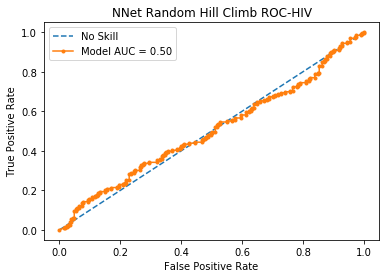

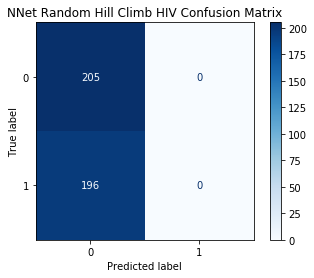

Y Test Acc
0.5112219451371571
Confusion Matrix
[[205   0]
 [196   0]]
Balanced Accuracy
0.5

simulated_annealing
Y Train Acc
0.5015615240474703
No Skill: ROC AUC=0.500
Model: ROC AUC=0.540


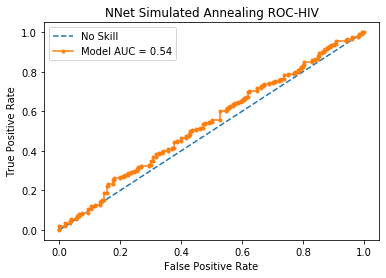

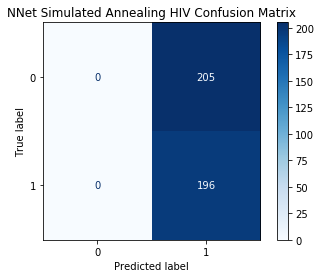

Y Test Acc
0.48877805486284287
Confusion Matrix
[[  0 205]
 [  0 196]]
Balanced Accuracy
0.5

genetic_alg
Y Train Acc
0.504684572142411
No Skill: ROC AUC=0.500
Model: ROC AUC=0.505


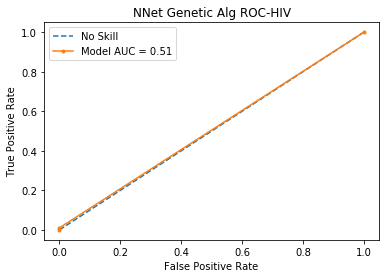

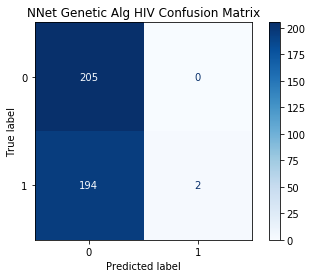

Y Test Acc
0.516209476309227
Confusion Matrix
[[205   0]
 [194   2]]
Balanced Accuracy
0.5051020408163265



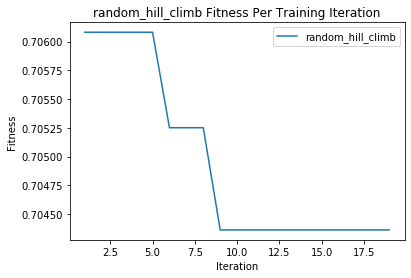

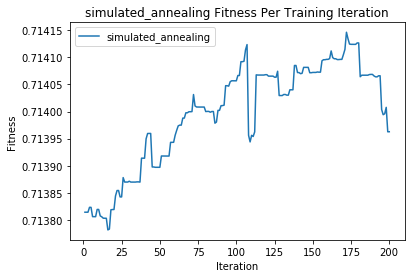

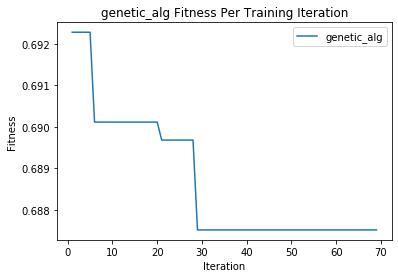

In [38]:
# optimizations from GridSearchCV
algos = {
    'random_hill_climb': 
    {'max_attempts': 10, 'max_iters': 300, 'mutation_prob': 0.1, 'pop_size': 200, 'restarts': 2, 'learning_rate': 0.1,
    'clip_max': 10000000000.0, 'schedule': mlrose.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)},
    'simulated_annealing': 
    {'max_attempts': 20, 'max_iters': 200, 'mutation_prob': 0.1, 'pop_size': 200, 'restarts': 0, 'learning_rate': 0.001,
    'clip_max': 10000000000.0, 'schedule': mlrose.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)},
    'genetic_alg': 
    {'max_attempts': 40, 'max_iters': 300, 'mutation_prob': .1, 'pop_size': 200, 'restarts': 0,  'learning_rate': 0.1,
    'clip_max': 10000000000.0, 'schedule': mlrose.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)}}

results = {'random_hill_climb':
           {'time': None, 'weights': None, 'loss': None, 'pred_probs': None, 'fitness_curve': None},
           'simulated_annealing': 
           {'time': None, 'weights': None, 'loss': None, 'pred_probs': None, 'fitness_curve': None},
           'genetic_alg': 
           {'time': None, 'weights': None, 'loss': None, 'pred_probs': None, 'fitness_curve': None}
          }
for key, value in algos.items():
    start = timeit.default_timer()
    nn = mlrose.NeuralNetwork(
        hidden_nodes = [5, 5, 5, 5], activation = 'relu', curve=True, algorithm=key, 
        max_iters=value['max_iters'], restarts=value['restarts'], bias=True, 
        is_classifier=True, learning_rate=value['learning_rate'], pop_size=value['pop_size'],
        early_stopping=True, clip_max=value['clip_max'], max_attempts=value['max_attempts'],
        mutation_prob=value['mutation_prob'], schedule=value['schedule'], random_state=0)
    nn.fit(x_train, y_train)
    end = timeit.default_timer() - start
    results[key]['time'] = end

    results[key]['weights'] = nn.fitted_weights
    results[key]['loss'] = nn.loss
    results[key]['pred_probs'] = nn.predicted_probs
    results[key]['fitness_curve'] = nn.fitness_curve
    
    # Predict labels for train set and assess accuracy
    y_train_pred = nn.predict(x_train)
    y_train_accuracy = accuracy_score(y_train, y_train_pred)
    print(key)
    print("Y Train Acc")
    print(y_train_accuracy)


    # Predict labels for test set and assess accuracy
    y_test_pred = nn.predict(x_test)
    
    # ROC
    plot_roc(nn, x_test, y_test, y_test_pred, 'NNet ' + key.replace('_', ' ').title() + ' ROC-HIV')

    
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    cm = plot_confusion_matrix(nn, x_test, y_test,
                                 display_labels=['0', '1'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    cm.ax_.set_title('NNet ' + key.replace('_', ' ').title() + ' HIV Confusion Matrix')
    plt.savefig('../images/cm_NNet_' + key + '_HIV.png')
    plt.show()
    
    y_test_accuracy = accuracy_score(y_test, y_test_pred)
    print("Y Test Acc")
    print(y_test_accuracy)
    
    # for unbalanced data
    print('Confusion Matrix')
    print(confusion_matrix(y_test, y_test_pred))
    print('Balanced Accuracy')
    print(balanced_accuracy_score(y_test, y_test_pred))
    
    print()
        
results = pd.DataFrame(results)
plot_results(results)

In [16]:
def plot_results(results):
    # Plot Fitness vs Iters
    for key, value in results.items():
        # fitness curve at each training iteration
        plt.plot(np.arange(1, len(value['fitness_curve']) + 1), value['fitness_curve'], label=key)
        plt.title(key + ' Fitness Per Training Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness')
        plt.legend()
        plt.savefig('../images/' + key + '_nnet_train_iter_v_fitness.png')
        plt.show()
        plt.clf()
        plt.close()